# Classification trials

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from io import StringIO
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn.metrics as mr
from azure.storage.blob import BlobServiceClient
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

In [3]:
%aimport src.altair_helpers
from src.altair_helpers import (
    plot_altair_grid,
    alt_plot_metric_based_threshold_tuning_plots,
)

%aimport src.business_helpers
from src.business_helpers import int_income_calculator

%aimport src.custom_learning_curve_helpers
from src.custom_learning_curve_helpers import learning_curve, manual_learning_curve

%aimport src.custom_looc_importance_helpers
from src.custom_looc_importance_helpers import manual_plot_looc_importance

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import create_pipe

%aimport src.custom_permutation_importance_helpers
from src.custom_permutation_importance_helpers import manual_plot_permutation_importance

%aimport src.custom_threshold_tuning_plotting_helpers
from src.custom_threshold_tuning_plotting_helpers import (
    # plot_cost_function_based_threshold_tuning_plots,
    plot_metric_based_threshold_tuning_plots,
)

%aimport src.custom_transformers
import src.custom_transformers as ct

# %aimport src.custom_returns_plotter
# from src.custom_returns_plotter import plot_returns

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import get_best_pipes, gridsearch

%aimport src.ml_metrics_v2
from src.ml_metrics_v2 import (
    threshold_roc_auc_score,
    threshold_fpr_score,
    threshold_f2_score,
    threshold_recall_score,
    pr_auc_score,
    get_scores,
    get_eval_metrics,
)

# %aimport src.threshold_tuning_helpers
# from src.threshold_tuning_helpers import (
#     get_components_of_returns,
#     threshold_tuning_reshaping,
# )

%aimport src.visualization_helpers
from src.visualization_helpers import (
    plot_learning_curve,
    builtin_plot_permutation_importances,
    plot_grouped_bar_chart,
    plot_grouped_histogram,
    plot_lower_corr_heatmap,
    plot_pr_roc_curves,
)

In [4]:
# load JS visualization code to notebook
shap.initjs()

In [5]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.width", 1000)

## About

This notebook will walk through machine learning classification experiments on the raw [Lending Club loans data](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F). A best-performing model will then be determined and assessed in the context of the business use case for this project.i.e. an conservative investor wanting to use the model developed here to predict which loan applications on the [Lending Club platform](https://www.lendingclub.com/), will not [default](https://en.wikipedia.org/wiki/Default_(finance)), and therefore should be funded by them.

## User Inputs

User inputs and helper functions, to be used later, are defined below

In [6]:
raw_data_file_path = "data/raw/lending_club_loans.csv"
cloud_storage = "no"

# From Feature Reduction
nan_threshold = 0.5
non_useful_cols = ["url", "desc"]
datetime_cols = ["issue_d", "last_pymnt_d"]
cols_one_eighteen = [
    "id",
    "member_id",
    "funded_amnt",
    "funded_amnt_inv",
    "grade",
    "sub_grade",
    "emp_title",
]
cols_eighteen_thirtysix = [
    "zip_code",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
]
cols_thirtyseven_end = [
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
]
loan_status = ["Fully Paid", "Charged Off"]
mapping_dictionary_labels = {"loan_status": {"Fully Paid": 1, "Charged Off": 0}}
four_or_less_value_columns = ["pymnt_plan"]

# From Feature Processing
more_than_one_pct_missing_columns = ["pub_rec_bankruptcies"]
datetime_cols_v2 = ["last_credit_pull_d", "earliest_cr_line"]
high_cardinality_cols = ["addr_state"]
mapping_dict_emp_length = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0,
    }
}
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
repeated_data_cols = ["title"]
pct_to_numeric_cols = ["int_rate", "revol_util"]

# From Exploratory Data Analysis 1/2
correlated_features = [
    "total_acc",
    "installment",
    "fico_range_low",
    "fico_range_high",
]
look_ahead_features = ["last_fico_range_low", "last_fico_range_high"]
raw_labels = ["loan_status"]
new_labels = ["is_default"]

cols_to_show = [
    "preprocessor_type",
    "resamplers",
    "threshold",
    "params",
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "mean_score_time",
    "clf_params",
]

thresholds_list = np.arange(0.01, 1, 0.01)

In [7]:
nan_threshold = float(nan_threshold)
for k in ["Fully Paid", "Charged Off"]:
    mapping_dictionary_labels["loan_status"][k] = int(
        mapping_dictionary_labels["loan_status"][k]
    )
for k in [
    "10+ years",
    "9 years",
    "8 years",
    "7 years",
    "6 years",
    "5 years",
    "4 years",
    "3 years",
    "2 years",
    "1 year",
    "< 1 year",
    "n/a",
]:
    mapping_dict_emp_length["emp_length"][k] = int(
        mapping_dict_emp_length["emp_length"][k]
    )

# From Exploratory Data Analysis 2/2
mapping_dict_new_labels = {"is_default": {0: 1, 1: 0}}

In [8]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "fpr": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=0.5,
    ),
    "f2": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "roc_auc_binary": mr.make_scorer(
        threshold_roc_auc_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "pr_auc": mr.make_scorer(
        pr_auc_score,
        greater_is_better=True,
        needs_proba=True,
    ),
}
cols_to_show = [
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_roc_auc_binary",
    "mean_test_pr_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_roc_auc_binary",
    "mean_train_pr_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "std_train_roc_auc_binary",
    "std_test_roc_auc_binary",
    "std_train_pr_auc",
    "std_test_pr_auc",
    "mean_score_time",
]

## Load data

Raw data from Lending Club is loaded into memory

In [9]:
if cloud_storage == "yes":
    az_storage_container_name = "myconedesx7"
    conn_str = (
        "DefaultEndpointsProtocol=https;"
        f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT')};"
        f"AccountKey={os.getenv('AZURE_STORAGE_KEY')};"
        f"EndpointSuffix={os.getenv('ENDPOINT_SUFFIX')}"
    )
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)

    blobstrings = {}
    for blob_name in ["blobedesz38"]:
        blob_client = blob_service_client.get_blob_client(
            container=az_storage_container_name, blob=blob_name
        )
        blobstring = blob_client.download_blob().content_as_text()
    df = pd.read_csv(StringIO(blobstring), skiprows=1, low_memory=False)
else:
    df = pd.read_csv(raw_data_file_path, skiprows=0, low_memory=False)

## Train-Test split

A hold-out set of the raw data will be set aside for model assessment

In [10]:
df_train_val, df_test = train_test_split(df, test_size=0.33, random_state=4321)
df_train, df_val = train_test_split(df_train_val, test_size=0.33, random_state=4321)

## Data processing

The raw data is cleaned, filtered and features are extracted/selected from this processed data in order to run experiments in classification

In [11]:
pipe_1_2_3 = Pipeline(
    [
        # nan_threshold=0.5, is a float in [0, 1.0] - CAN CHANGE OR KEEP UNCHANGED
        ("nanthresh", ct.DFNanThresholdColumnDropper(0.5)),
        ("nouse", ct.DFColumnDropper(non_useful_cols)),
        ("dtime", ct.DFColumnDropper(datetime_cols)),
        ("c1", ct.DFColumnDropper(cols_one_eighteen)),
        ("c2", ct.DFColumnDropper(cols_eighteen_thirtysix)),
        ("c3", ct.DFColumnDropper(cols_thirtyseven_end)),
        (
            "mapstatus",
            ct.DFColumnFilterList("loan_status", loan_status),
        ),
        ("colmap", ct.DFColumnMapper(mapping_dictionary_labels)),
        ("onevals", ct.DFNonUniqueValColDropper(num_non_unique_vals=1)),
        # four_or_less_value_columns=['pymnt_plan'] - 'pymnt_plan' is MOSTLY 'n', EXCLUDE
        ("fourvals", ct.DFColumnDropper(four_or_less_value_columns)),
        # more_than_one_pct_missing_columns = ['pub_rec_bankruptcies']
        ("morethan1pctnan", ct.DFColumnDropper(more_than_one_pct_missing_columns)),
        ("nan", ct.DFDropNaN()),
        # high_cardinality_cols=['addr_state'] - CAN INCLUDE OR EXCLUDE
        ("hcardcols", ct.DFColumnDropper(high_cardinality_cols)),
        ("dtimev2", ct.DFColumnDropper(datetime_cols_v2)),
        ("texttonum", ct.DFColumnMapper(mapping_dict_emp_length)),
        ("repeats", ct.DFColumnDropper(repeated_data_cols)),
        ("pctcols", ct.DFPctNumeric(pct_to_numeric_cols, "%")),
        (
            "singlecolmap",
            ct.DFSingleColumnMapper("loan_status", mapping_dict_new_labels),
        ),
        ("dtype", ct.DFSimpleDtypeChanger(new_labels, "int")),
        # n_std is an integer - CAN CHANGE OR KEEP UNCHANGED
        ("stdfilter", ct.DFColumnStdFilter("annual_inc", 3)),
        # correlated_features=['total_acc','installment','fico_range_low','fico_range_high'] EXCLUDE
        ("corr", ct.DFColumnDropper(correlated_features)),
        ("lookahead", ct.DFColumnDropper(look_ahead_features)),
        ("label", ct.DFColumnDropper(raw_labels)),
        # requires ("corr", ...) to be removed; threshold=1, ideally chosen from dendogram
        # ("clusterselect", ct.DFHierarchicalClusterSpearmanRank(threshold=1)),
    ]
)
df_pipe_transformed_train = pipe_1_2_3.fit_transform(df_train)
df_pipe_transformed_val = pipe_1_2_3.transform(df_val)
df_pipe_transformed_train_val = pipe_1_2_3.transform(df_train_val)
df_pipe_transformed_test = pipe_1_2_3.transform(df_test)
print(df_pipe_transformed_train.shape)
print(df_pipe_transformed_val.shape)
print(df_pipe_transformed_train_val.shape)
print(df_pipe_transformed_test.shape)
display(df_pipe_transformed_train.head(2))
display(df_pipe_transformed_val.head(2))
display(df_pipe_transformed_train_val.head(2))
display(df_pipe_transformed_test.head(2))
display(df_pipe_transformed_train["is_default"].squeeze().value_counts(dropna=False))

(16998, 16)
(8347, 16)
(25361, 16)
(12469, 16)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
39296,15250.0,36 months,11.34,10,MORTGAGE,75000.0,Not Verified,debt_consolidation,15.14,0.0,0.0,11.0,0.0,39702.0,84.5,0
2652,6000.0,36 months,15.96,4,RENT,72000.0,Not Verified,credit_card,4.15,0.0,2.0,7.0,0.0,7600.0,82.6,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,1
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,1


0    14547
1     2451
Name: is_default, dtype: int64

## Get features and class labels from processed data

The features and labels are now extracted from the processed training and testing splits

In [12]:
X_train = df_pipe_transformed_train.drop(labels=new_labels, axis=1)
y_train = df_pipe_transformed_train[new_labels].astype(int).squeeze()
X_val = df_pipe_transformed_val.drop(labels=new_labels, axis=1)
y_val = df_pipe_transformed_val[new_labels].astype(int).squeeze()
X_train_val = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_train_val = df_pipe_transformed_test[new_labels].astype(int).squeeze()
X_test = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_test = df_pipe_transformed_test[new_labels].astype(int).squeeze()
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))
display(X_train_val.head(2))
display(y_train.to_frame().head(2))
display(y_val.to_frame().head(2))
display(y_test.to_frame().head(2))
display(y_train_val.to_frame().head(2))

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2


,is_default
36400,0
20156,0


,is_default
22692,0
13071,0


,is_default
9990,1
27119,1


,is_default
9990,1
27119,1


## Assemble components for `GridSearchCV`

The pipeline inputs and other components required for hyperparameter optimization using `GridSearchCV` are extracted here

### Lists of features by type

A list of numerical and categorical features is extracted from the processed data
- numerical features are those with a datatype of `float`
- categorical features are those that do not have a datatype of `float`

In [13]:
numerical_columns = [
    c
    for c in list(X_train.select_dtypes(exclude="object"))
    if c not in new_labels + ["emp_length"]
]
nominal_columns = list(X_train.select_dtypes(include="object")) + ["emp_length"]
try:
    assert set(numerical_columns + nominal_columns) == set(list(X_train)) - set(
        new_labels
    )
    print("Columns from training data match feature lists")
except AssertionError as e:
    print("Some columns from training data are missing from feature lists")
print("Categoricals:\n-" + "\n-".join(nominal_columns))
print("Numericals:\n-" + "\n-".join(numerical_columns))

Columns from training data match feature lists
Categoricals:
-term
-home_ownership
-verification_status
-purpose
-emp_length
Numericals:
-loan_amnt
-int_rate
-annual_inc
-dti
-delinq_2yrs
-inq_last_6mths
-open_acc
-pub_rec
-revol_bal
-revol_util


### Feature transformations

Below, feature transformations to be applied to all numerical columns are defined. With or without transformations, all numerical features will be normalized. All categorical features will be one-hot encoded.

In [14]:
col_transformers = {
    c: Pipeline(
        steps=[
            ("trans", ct.DFPowerTransformer("yeo-johnson")),
            ("ss", ct.DFStandardScaler()),
        ]
    )
    for c in numerical_columns
}
preprocessors = {
    "no_trans": ColumnTransformer(
        transformers=[
            (
                "nums",
                Pipeline(steps=[("trans", StandardScaler())]),
                numerical_columns,
            )
        ]
        + [("onehot", ct.DFOneHotEncoderV2(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
    "trans": ColumnTransformer(
        transformers=[(k, v, [k]) for k, v in col_transformers.items()]
        + [("onehot", ct.DFOneHotEncoderV2(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
}
feat_selector = ct.DFCorrColumnDropper(0.5, "spearman")

### Classifiers and hyper-parameters for optimization

The models to be compared, discrimination threshold(s) (to be applied to all listed models), and dictionaries of model hyper-parameters for tuning, are defined below
- for hyper-parameter dictionaries containing cost-function weights, for manual specification of the penalties used in the algorithm's cost function, the larger penalty should be assigned to the minority class (see [**Lesson 07. Cost-Sensitive Algorithms**](https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/))
  - here, this is for the positive class where `is_default`==1, and is explicitly shown below through the class-balance of the labels from the training data

In [15]:
y_train.value_counts().to_frame()

,is_default
0,14547
1,2451


In [16]:
vc = np.unique(y_train, return_counts=True)[1]
minority_weight = vc[0] / vc[1]
parameters = {
    "LogisticRegression": {
        "C": [1.0],
        "class_weight": [
            "balanced",
            None,
            {0: 1, 1: 1},
            {0: 1, 1: minority_weight},
            {0: 1, 1: 8},
        ],
    },
    "DummyClassifier": {"strategy": ["stratified"]},
}

In [17]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=False)
df_gs = gridsearch(
    X_train,
    y_train,
    parameters,
    preprocessors["no_trans"],
    feat_selector,
    cv,
    multi_scorers,
    threshold=0.5,
)
param_cols = df_gs.columns[
    df_gs.columns.to_series().str.contains("param_")
].tolist()
display(df_gs[["clf"]+param_cols+cols_to_show])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    3.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


,clf,param_clf__C,param_clf__class_weight,param_clf__strategy,mean_test_recall_binary,mean_test_fpr,mean_test_roc_auc_binary,mean_test_pr_auc,mean_train_recall_binary,mean_train_fpr,mean_train_roc_auc_binary,mean_train_pr_auc,mean_fit_time,std_train_recall_binary,std_test_recall_binary,std_train_fpr,std_test_fpr,std_train_roc_auc_binary,std_test_roc_auc_binary,std_train_pr_auc,std_test_pr_auc,mean_score_time
0,LogisticRegression,1,balanced,NaN,0.627089,0.342271,0.642409,0.287359,0.644838,0.340397,0.652221,0.293751,1.276421,0.005445,0.020331,0.002600,0.009327,0.003404,0.010913,0.002691,0.010822,0.036870
1,LogisticRegression,1,None,NaN,0.022036,0.003918,0.509059,0.287427,0.023562,0.003471,0.510045,0.295787,1.408794,0.001921,0.005979,0.000500,0.001350,0.001076,0.002560,0.002800,0.010626,0.034714
2,LogisticRegression,1,"{0: 1, 1: 1}",NaN,0.022036,0.003918,0.509059,0.287427,0.023562,0.003471,0.510045,0.295787,1.351707,0.001921,0.005979,0.000500,0.001350,0.001076,0.002560,0.002800,0.010626,0.032712
3,LogisticRegression,1,"{0: 1, 1: 5.935128518971848}",NaN,0.627497,0.342477,0.642510,0.287318,0.644838,0.340379,0.652229,0.293741,1.244016,0.005391,0.020213,0.002588,0.009207,0.003417,0.010845,0.002696,0.010834,0.033130
4,LogisticRegression,1,"{0: 1, 1: 8}",NaN,0.764175,0.486287,0.638944,0.287080,0.777336,0.484206,0.646565,0.293396,1.112055,0.000740,0.019294,0.004925,0.007961,0.002692,0.009963,0.002680,0.010867,0.020250
5,DummyClassifier,NaN,NaN,stratified,0.152179,0.142435,0.504872,0.213493,0.154019,0.141180,0.506419,0.215637,0.255769,0.003669,0.011319,0.000614,0.001917,0.002142,0.006618,0.003403,0.010556,0.016542


CPU times: user 1.13 s, sys: 1.73 s, total: 2.86 s
Wall time: 5.23 s


In [18]:
best_cfg_idx = 0
best_dummy_cfg_idx = 5
best_pipe, best_dummy_pipe = get_best_pipes(
    best_cfg_idx,
    best_dummy_cfg_idx,
    df_gs,
    preprocessors["no_trans"],
    feat_selector,
    param_cols,
)

In [19]:
%%time
best_pipe.fit(X_train, y_train)
best_dummy_pipe.fit(X_train, y_train)
y_probs_val = best_pipe.predict_proba(X_val)[:, 1]

CPU times: user 900 ms, sys: 1.74 s, total: 2.64 s
Wall time: 427 ms


,best_threshold,score
ROC-AUC,0.47,0.639786
Precision,0.93,1.000000
Recall,0.01,1.000000
F1,0.36,0.693123
FPR,0.01,1.000000
F2,0.18,0.837054


CPU times: user 253 ms, sys: 324 ms, total: 577 ms
Wall time: 553 ms


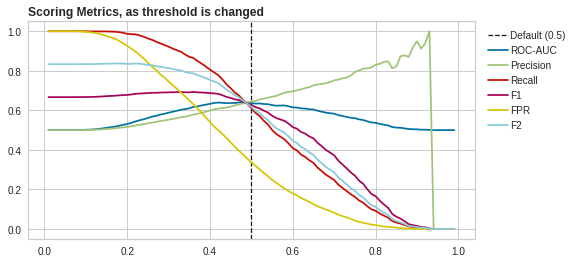

In [20]:
%%time
(
    df_threshold_tuning_scores,
    df_all_threshold_tuning_scores
) = plot_metric_based_threshold_tuning_plots(
    y_val,
    y_probs_val,
    thresholds_list,
    f2_beta=2,
    legend_position=(1.01, 1),
    show_best_t_by_f1=False,
    show_plot=True,
    fig_size=(8, 4),
)
display(df_threshold_tuning_scores)

Depending on your specific use case, you may want to tune your parameters to achieve better results in precision or recall.

In our specific example, is it better to

- Provide a loan to somone who will default
- Deny a loan to someone who will not defaul

These are the questions you need to validate with your stakeholders and take into account when building your model.

1. this is the sum of `n` [monthly returns](https://www.vertex42.com/ExcelArticles/amortization-calculation.html) that a prospective funder of the loan would expect to receive if the loan is paid off on time
2. Why divide by `len(y_test)`?
   - If every loan had these r,n,p, anbd other factos were consisnt, and taking the model's predictive power into account, then the average return would be given by `ds /= len(y_test)`

#### Methodology for tuning threshold

An alternative approach to tune the discrimination threshold involves optimizing the total return earned (or lost) by an investor that only follows the predictions of the ML model when deciding whether a loan will result in a default (investor does not fund) or will be paid off on time (investor provides funding).

The total return earned on a loan is the sum of monthly payments made by the borrower. A monthly payment for a loan can be calculated using the formula ([1](https://www.kasasa.com/blog/how-to-calculate-loan-payments-in-3-easy-steps), [2](https://www.vertex42.com/ExcelArticles/amortization-calculation.html), [3](https://www.calculator.net/payment-calculator.html), [4](https://www.thebalance.com/loan-payment-calculations-315564)) below

![\Large A=P\frac{r{(1+r)^n}}{(1+r)^n-1}](https://latex.codecogs.com/svg.latex?\Large&space;A=P\frac{r(1+r)^n}{(1+r)^n-1})

The three terms in this formula for monthly interest payment (`A`) are in the Lending Club dataset
- `int_rate` is the interest rate per year (`r`), expressed as a percentage
  - this will have to be divided by 12 to get the monthly interest rate due on the loan
- `loan_amnt` is the principal (`P`), or value of the loan in dollars (USD)
- `term` is the length of time that a borrower has to repay the loan (`n`), in months and so the number of periodic (monthly) payments that are to be made on the loan
  - for the dataset here, this is 36 or 60 months

This calculation is a simplification for the following reasons
- it is assumed that a default occurs immediately on receipt of the loan and so no monthly paymetns are ever made by the borrower. If some monthly payments were in fact made (without defaulting), then
  - the difference between the principal and the sum of the monthly payments would be the loss incurred by the investor, upon the loan going into default, and not the entire principal
  - penalties in the form of higher interest rates would apply to subsequent payments but  are not accounted for

Using this formula, the monthly payment amount (`A`) can be calculated in dollars and it matches the value found in the `installment` column of the data, though that column is not used as an ML feature here. The sum of all the monthly payments (36 or 60) is the total interest payment on the loan (A<sub>t</sub>). Note that `A` is the total monthly payment including interest. The interest component of the first monthly payment (`A`) is `r` X `P` and the new principal after the first payment is made would be `P` - `A`. The interest component of the second monthly payment is `r` X (`P` - `A`) and so on.

Here, the total of all the monthly payments on a loan (A<sub>t</sub>) is calculated in Python for all loans in the validation split of the data using a helper function `int_income_calculator()` found in `src/business_helpers.py`.

This total income earned by an investor is used in determining the prospective return that can be earned per loan by relying on the predictions made by the ML model being developed here. A positive return indicates the investor could receive funds by relying on the ML model, while a negative return indicates that the investor would actually lose money if they relied on the ML model when deciding whether to fund the loan or not.

Recalling that the positive class here is that a borrower will default and the negative class is that the loan will be paid off on time, the four types of outcomes that need to be considered when estimating the returns earned by relying on the ML model's predictions and are discussed below
1. If an ML model predicts a loan will be paid on time and it actually is, then this is the overall return that an investor will theoretically earn by funding the loan. This is the cost of a True Negative.
2. If the ML model predicts the loan will result in a default and the loan is actually paid off on time, then this is the prospective loss incurred by the investor by not funding the loan. Since the investor follows the model's recommendation, and does not provide funding, principal is not lost. However, return was there to be earned - and it wasn't! So, the return is lost. This is the cost of a False Positive.
3. If the ML model predicts that the loan will be paid off on time and it actually defaults, then the principal is lost. Return was never there to be earned since the loan would have defaulted - it was going to be lost, but the model predicted the opposite. So, the return wasn't lost, but the princpal is. A simplifying assumption is made here: the borrower never made any monthly payments. This is a conservative estimate in the sense that the borrower may make a few of the required monthly payments before defaulting on the loan (when a loan payment is 121 days past due). So, the full principal may not be lost in this case. By assuming the worst case scenario (no payments made), this provides an upper bound on the funds that could be lost by a prospective investor. This is an important factor for a conservative investor - the intentend end user of the ML model being developed here. This is the cost of a False Negative.
4. If the ML model predicts that the loan will result in a default and this does happen, then neither principal nor return are lost. There was no return to be made so return was not lost. Since the investor followed the recommendations of the ML model and did not provide funding, no principal was lost either. This is the cost (or lack thereof) of a True Positive.

Using these four outcomes, the ML model's predicted return on a loan can be estimated using the formula below

![\Large R(t)=-(P)XFN(t)+(0)TP(t)+(-A_t)FP(t)+(A_t)TN(t)](https://latex.codecogs.com/svg.latex?\Large&space;R(t)=-(P)FN(t)+(0)TP(t)+(-A_t)FP(t)+(A_t)TN(t))

where `FN(t)`, `FP(t)`, `TN(t)` and `TP(t)` are the number of false negatives, false positives, true negatives and true positives respectively and can be extracted from a [confusion matrix](https://classeval.wordpress.com/introduction/basic-evaluation-measures/). Each of these is a function of the discrimination threshold - this means the choice of threshold determines the number of false negatives, true positives, etc. predicted by the model. `R(t)` also depends on the threshold. When applied to the ML model's prediction of a outcome of a single loan, three of `FN`, `FP`, `TN` and `TP` are 0 and the fourth value is 1. `P` is the principal for the loan in question and A<sub>t</sub> is the theoretical return (total of all the monthly payments) that could be earned or lost and was calculated above. Each of `FN`, `FP`, `TN` and `TP` is a function of the discrimination threshold, `t`.

`R(t)` above can be computed for the ML model's predictions of the class labels (R<sub>pred</sub>(t)) and for the true labels (R<sub>true</sub>(t)). The optimal value of `t` is one that minimizes the mean absolute difference between predicted (R<sub>pred</sub>(t)) and true (R<sub>true</sub>(t)) returns across all loans being considered in the data

![\Large AE(t)=|R_{pred}(t)-R_{true}(t)|](https://latex.codecogs.com/svg.latex?\Large&space;AE(t)=|R_{pred}(t)-R_{true}(t)|)

![\Large MAE(t)=\overline{AE(t)}=\frac{AE(t)}{len(R_{pred})}](https://latex.codecogs.com/svg.latex?\Large&space;MAE(t)=\overline{AE(t)}=\frac{AE(t)}{len(R_{pred})})

This optimized discrimination threshold is taken as the best value for the business use case being analyzed here. This optimal `t` will **not** necessarily agree with the choice of `t` that optimizes the ML scoring metrics as shown in the table above (see the `best_threshold` column) - instead, it is an alternative to the one that is designed to optimize ML scoring metrics.

#### Technical details of threshold tuning

1. Starting with the best model found from hyper-parameter optimization, extract the columns required to calculate the total of all monthly payments on the loans in the data - these are `int_rate`, `loan_amnt` and `term`. The helper function `int_rate_calculator()` computes the total return on a single loan and it will be vectorized to perform this computation on all the loans in the validation split. This gives a single column of the total return for each loan.
2. Why the validation split? Since the best model was already determined during hyper-parameter tuning, it will be re-used. As hyper-parameters were tuned on the training split, the trained (best) model will not be re-trained during threshold tuning. Instead, it will be used to generate the class prediction probabilities for all observations in the validation split.
3. A helper function `rowwise_calculate_avg_return_vs_theoretical()` is used to calculate the difference between the ML model's predicted return on a single loan using the formula for `Returns(t)` defined earlier. This functin will use
   - predicted probability (converted to a hard label - 0 or 1) and corresponding true value from the validation split
   - principal, since this is the penalty for a false negative
   - total loan income
     - this is the output of vectorizing the `int_rate_calculator()` helper function

   in order to calculate the predicted and true return for each loan. Using a single predicted (hard) class label and the corresponding true label (`confusion_matrix(y_pred, y_true)`), a confusion matrix similar to

   |          | predicted=0 | predicted=1 |
   |---------:|------------:|------------:|
   | actual=0 |           1 |           0 |
   | actual=1 |           0 |           0 |

   is generated and used to extract the (number of) `FN`, `FP`, `TN` and `TP`. In this table, the ML model predicts the loan is paid off on time and the true outcome is also that the loan is paid off on time. Three of the entries in the confusion matrix will be 0 and the other will be 1 - in the above table, `FP` is 0 and the others are 1. Combining these with the principal (`P`) and total loan income (A<sub>t</sub>), the predicted return can be calculated for the loan. For computing the true return, the predicted class label is represented by the true label (`confusion_matrix(y_true, y_true)`) and the confusion matrix is similarly used.
4. The difference between the predicted and true return is then computed and the average differrence across all loans will be used as the `MAE` scoring metric, as explained above, for tuning the discrimination threshold of the ML model.

In [21]:
from multiprocessing import cpu_count

from joblib import Parallel, delayed
import matplotlib.ticker as mtick
import scipy.stats as st

%aimport src.business_helpers
from src.business_helpers import calculate_avg_return_vs_theoretical_v2

%aimport src.visualization_helpers
from src.visualization_helpers import add_gridlines, customize_splines

In [22]:
def score_single_threshold(X, y, pipe, t):
    start_time = time()
    score = calculate_avg_return_vs_theoretical_v2(X, y, pipe, t)
    duration = time() - start_time
    five_percentile, ninetyfive_percentile = st.t.interval(
        0.95, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    twentyfive_percentile, seventyfive_percentile = st.t.interval(
        0.75, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    fifty_percentile, _ = st.t.interval(
        0.50, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    r = {
        "label": type(pipe.named_steps["clf"]).__name__,
        "threshold": t,
        "mae": score.mean(),
        "mdae": score.median(),
        "stdae": score.std(),
        "count": score.count(),
        "whislo": five_percentile,
        "whishi": ninetyfive_percentile,
        "q1": twentyfive_percentile,
        "med": fifty_percentile,
        "q3": seventyfive_percentile,
        "fliers": [],
        "duration": duration,
    }
    print(
        f"Model = {type(pipe.named_steps['clf']).__name__}, "
        f"threshold = {t}, duration = {duration:.2f} sec\n"
    )
    return r

In [23]:
def threshold_tuning_reshaping(df_t_tuned, get_relative_score=False):
    if get_relative_score:
        df_t_tuned = df_t_tuned.assign(
            relative_mae=(df_t_tuned["mae"] / df_t_tuned["mae"].max())
        ).drop(["mae", "stdae", "count"], axis=1)
    df_t_tuned = (
        df_t_tuned.set_index("threshold")
        .unstack()
        .reset_index()
        .rename(columns={"level_0": "metric", 0: "value"})
    )
    return df_t_tuned

In [24]:
def compute_cost_for_thresholds(
    thresholds, X_test, y_test, pipe, get_relative_score=False
):
    executor = Parallel(n_jobs=cpu_count(), backend="multiprocessing")
    tasks = (
        delayed(score_single_threshold)(
            X_test,
            y_test,
            pipe,
            t,
        )
        for t in thresholds
    )
    d = executor(tasks)
    df_cost_func = pd.DataFrame.from_records(d)
    df_cost_func = threshold_tuning_reshaping(df_cost_func, get_relative_score)
    return df_cost_func

In [25]:
%%time
df_cost_func_tuning = compute_cost_for_thresholds(thresholds_list, X_val, y_val, best_pipe, True)
display(df_cost_func_tuning.head(10))

Model = LogisticRegression, threshold = 0.02, duration = 12.37 sec

Model = LogisticRegression, threshold = 0.06999999999999999, duration = 12.37 sec

Model = LogisticRegression, threshold = 0.060000000000000005, duration = 12.41 sec

Model = LogisticRegression, threshold = 0.04, duration = 12.51 sec

Model = LogisticRegression, threshold = 0.08, duration = 12.54 sec

Model = LogisticRegression, threshold = 0.01, duration = 12.88 sec

Model = LogisticRegression, threshold = 0.09999999999999999, duration = 12.92 sec

Model = LogisticRegression, threshold = 0.03, duration = 13.09 sec

Model = LogisticRegression, threshold = 0.12, duration = 13.21 sec

Model = LogisticRegression, threshold = 0.09, duration = 13.28 sec

Model = LogisticRegression, threshold = 0.05, duration = 13.39 sec

Model = LogisticRegression, threshold = 0.11, duration = 13.61 sec

Model = LogisticRegression, threshold = 0.13, duration = 12.85 sec

Model = LogisticRegression, threshold = 0.14, duration = 13.04 sec

Mo

,metric,threshold,value
0,label,0.01,LogisticRegression
1,label,0.02,LogisticRegression
2,label,0.03,LogisticRegression
3,label,0.04,LogisticRegression
4,label,0.05,LogisticRegression
5,label,0.06,LogisticRegression
6,label,0.07,LogisticRegression
7,label,0.08,LogisticRegression
8,label,0.09,LogisticRegression
9,label,0.10,LogisticRegression


CPU times: user 699 ms, sys: 151 ms, total: 850 ms
Wall time: 2min


In [26]:
alt_plot_metric_based_threshold_tuning_plots(
    pd.concat(
        [
            df_all_threshold_tuning_scores,
            df_cost_func_tuning[df_cost_func_tuning["metric"] == "relative_mae"],
        ]
    ),
    ptitle_offset=-5,
    legend_offset=5,
    figsize=(450, 300),
)

alt.LayerChart(...)

In [27]:
# MANUAL SELECTION, BASED ON ABOVE PLOT
best_t = 0.75

In [28]:
%%time
dfcts = []
for pipe in [best_dummy_pipe, best_pipe]:
    df_cost_func = compute_cost_for_thresholds([best_t], X_val, y_val, pipe, False).assign(clf=type(pipe.named_steps['clf']).__name__)
    dfcts.append(df_cost_func)
df_cost_funcs = pd.concat(dfcts, ignore_index=True)
df_cost_funcs = df_cost_funcs.pivot(index="metric", columns="clf", values="value")
display(df_cost_funcs)

Model = DummyClassifier, threshold = 0.75, duration = 6.42 sec

Model = LogisticRegression, threshold = 0.75, duration = 6.49 sec



clf,DummyClassifier,LogisticRegression
metric,,
count,8347,8347
duration,6.42374,6.49008
fliers,[],[]
label,DummyClassifier,LogisticRegression
mae,2108.88,1911.31
mdae,0,0
med,2069.07,1869.08
q1,2040.98,1839.28
q3,2176.78,1983.34


CPU times: user 118 ms, sys: 114 ms, total: 232 ms
Wall time: 13.2 s


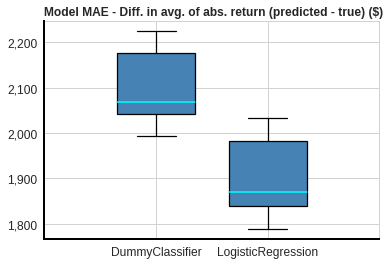

In [29]:
bxp_cols = ["label", "whislo", "q1", "med", "q3", "whishi", "fliers"]
boxes = [
    df_cost_funcs.loc[
        bxp_cols, type(best_dummy_pipe.named_steps["clf"]).__name__
    ].to_dict(),
    df_cost_funcs.loc[bxp_cols, type(best_pipe.named_steps["clf"]).__name__].to_dict(),
]
axis_tick_label_fontsize = 12
fig, ax = plt.subplots(figsize=(6, 4))
bxp1 = ax.bxp(
    boxes,
    positions=[1, 1.5],
    widths=0.35,
    showfliers=False,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.25, color="black"),
    capprops=dict(linewidth=1.25, color="black"),
    boxprops=dict(linewidth=1.25),
    medianprops=dict(linewidth=1.5, color="cyan"),
)
for patch in bxp1["boxes"]:
    patch.set(facecolor="steelblue")
ax.xaxis.set_tick_params(labelsize=axis_tick_label_fontsize)
ax.yaxis.set_tick_params(labelsize=axis_tick_label_fontsize)
ax.grid(which="both", axis="both", color="lightgrey", zorder=0)
_ = customize_splines(ax)
_ = add_gridlines(ax)
ax.set_xlabel(None)
ax.set_title(
    "Model MAE - Diff. in avg. of abs. return (predicted - true) ($)",
    loc="left",
    fontweight="bold",
)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

In [ ]:
# %%time
# df_returns_t_tuned, df_returns_t_tuning_full = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, thresholds_list)
# display(df_returns_t_tuned)
# display(df_returns_t_tuning_full.head())

In [ ]:
# %%time
# best_t = 0.75
# df_returns_best_t, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, [best_t])
# df_returns_best_t = threshold_tuning_reshaping(df_returns_best_t)
# display(df_returns_best_t)

In [ ]:
# plot_returns(
#     df_returns_best_t.sort_values(by=["clf", "return"], ascending=[False, False]),
#     ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
#     annotation_text=f"*using optimal discrimination threshold ({best_t})",
#     axis_tick_fontsize=12,
#     annotation_text_fontsize=10,
#     annotation_loc=(0.99, 0.01),
#     fig_size=(8, 4),
# )

1. It is average becuase the model will not alwyas predict that you should fund such a loan. There are times when it incorrectly predicts that the loan should not be funded - in such a scenario, prospective return is lost. If you used an independent methd of predicting loans to fund, and the loan was paid off on time, then the return you earn would be the theoretical return from the above graph/table.

In [30]:
%%time
best_pipe.fit(X_train_val, y_train_val)
best_dummy_pipe.fit(X_train_val, y_train_val)
y_probs_test = best_pipe.predict_proba(X_test)[:, 1]

CPU times: user 876 ms, sys: 1.96 s, total: 2.84 s
Wall time: 393 ms


In [ ]:
# %%time
# df_returns_best_t_test, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_test, y_test, confs_test, [best_t])
# df_returns_best_t_test = threshold_tuning_reshaping(df_returns_best_t_test)
# display(df_returns_best_t_test)

In [ ]:
# plot_returns(
#     df_returns_best_t_test.sort_values(by=["clf", "return"], ascending=[False, False]),
#     ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
#     annotation_text=f"*using optimal discrimination threshold ({best_t})",
#     axis_tick_fontsize=12,
#     annotation_text_fontsize=10,
#     annotation_loc=(0.99, 0.01),
#     fig_size=(8, 4),
# )

## Model Evaluation

### ML Diagnostic metrics and plots

In [31]:
df_scores, y_pred_test_selected_threshold = get_eval_metrics(
    y_test.to_numpy(), y_probs_test, split="test", threshold=best_t, beta=2
)
display(df_scores.T)

,0
test_recall_binary,0.161491
test_fpr,0.047859
test_f2,0.191824
test_pr_auc,0.276516
test_roc_auc,0.556816


In [32]:
df_cm = (
    pd.DataFrame(
        mr.confusion_matrix(
            y_test,
            y_pred_test_selected_threshold,
            labels=np.sort(np.unique(y_train_val)),
        ),
        index=np.sort(np.unique(y_train_val)),
        columns=np.sort(np.unique(y_train_val)),
    )
    .rename_axis("actual", axis="columns")
    .rename_axis("predicted", axis="rows")
)
df_cr = pd.DataFrame(
    mr.classification_report(
        y_test,
        y_pred_test_selected_threshold,
        target_names=np.sort(np.unique(y_train_val)),
        output_dict=True,
    )
).T
plot_altair_grid(
    df_cm,
    df_cr,
    ptitle_offset=-5,
    cpe_figsize=(150, 300),
    cm_figsize=(150, 300),
    cr_figsize=[(250, 300), (100, 300)],
)

alt.HConcatChart(...)

**Observations**
1. The poor performance is not surprising since the threshold was optimized on the cost function of predicted loan return. Each of these metrics had an optimal threshold region that was different from the threshold that maximized the difference in the prediction error expressed as a cost function - the average error in the model's predicted returns.
2. By definition, `TPR` and `F2` are close to eachother since they minimize `FN`. This was also seen earlier in the metric-based threshold tuning plots and is again observed here.

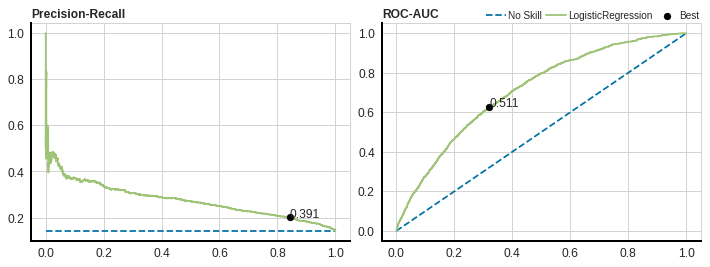

In [33]:
plot_pr_roc_curves(
    y_test,
    y_probs_test,
    type(best_pipe.named_steps["clf"]).__name__,
    axis_tick_label_fontsize=12,
    wspace=0.1,
    legend_position=(0.3, 1.1),
    f2_beta=2,
    fig_size=(12, 4),
)

**Observations**
1. Interpreting the ROC-AUC curve
   - On average, a model with skill gives a higher probability to a randomly chosen real positive outcome than a negative one.
   - A model with perfect skill is depicted as a point at `(0, 1)` (top left of the plot)
     - A model with skill produces a ROC-AUC curve that expands from the 45-degree line up to the top left of the plot.
2. Interpreting the Precision-Recall curve
   - A model with skill can discriminate between classes and does not predict a random class or a constant class in all cases.
   - The no-skill line is a horizontal line with the value of the ratio of positive cases in the dataset. Its value depends on the relative balance between positive to negative classes. For a prefectly balanced dataset, this ratio is 0.5, which is clearly not the case here.
     - for the test set here, `y_test.value_counts().to_dict()` gives `{0: 10698, 1: 1771}` and so the no-skill line is drawn at `1771/10698 = 0.1655`
   - A model with perfect skill is depicted as a point at `(1, 1)` (top right of the plot)
   - A model with skill produces a Precision-Recall curve that expands from the horizontal line, at the bottom, to the top right of the plot and is well above the horizontal line of no skill.
3. Given the imbalance in the classes here, more importance should be given to the Precision-Recall curve than to the ROC-AUC curve.
4. While both plots are clearly sub-optimal, it is reassuring that the best model found here is better than one that has no skill.
5. The optimal threshold is marked as a circle with an annotation on the
   - ROC-AUC curve
     - This is the threshold with the optimal balance between false positive and true positive rates as determined by optimizing the Geometric Mean
   - Precision-Recall curve
     - This is the threshold with the the best balance of precision and recall as determined by as optimizing the [F2 score](https://clusteval.sdu.dk/1/clustering_quality_measures/14)

### Proxies for Feature Importance

In this section, techniques for post-hoc interpretation to understand the ML model's predictions will be explored. Although the training split may be used, only the test split will be used for interpretations in the following sub-sections since the predictive power of each feature on unseen data is ultimately of interest.

#### Model-Neutral Permutation Importance

In permutation importance ([1](https://academic.oup.com/bioinformatics/article/26/10/1340/193348), [2](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/mlx/permutation_importance.html#description)), each ML feature is separately shuffled and used as an input for modeling. The difference in scoring metric with and without this shuffling is taken as the importance of the column being randomized to the model. This process is repeated for each column individually. The larger the difference, the more important the feature to the ML model. It provides a model agnostic indication of the importance of each feature, independent of how the algorithm's coefficients/importances are computed. The method requires the absence of multi-collinearity between ML features and that is the case here as correlated features were manually removed during exploratory data analysis (see `3_*.ipynb`).

**Methodology Used**
1. For a given (`r`, `n`, `P`), calculate
   - predicted return per loan ( `A` )
     - calculate predicted return from confusion matrix, using formula for `R(t)` defined earlier
       - this takes ML model's predictive power into account
   - true return per loan (`B`)
2. Calculate difference between predicted and true return `AE`, which was defined earlier
3. Calculate mean of all differences in the testing data
   - this gives the average difference between the predicted and true return over all the loans in the test split (`MAE`, which was defined earlier)
   - this is the baseline score
4. Shuffle a single ML feature and re-calculate the mean of all differences (`MAE1`) from step 3.
4. Calculate difference (`D1`) bewteen mean values found in steps 3. (without shuffling, the baseline `MAE`) and 4. (with shuffling, `MAE1`)
5. Repeat steps 1. to 4. `n_repeats` times
   - in other words, shuffle the same column `n_repeats` times and calculate the differences (`D2`, ..., `D10`) between the predicted and true returns
6. Plot a boxplot of all the differences `D1`, ..., `D10`

Below is a boxplot highlighting the impact on model performance, separately using the TPR (minimizes `FN`), FPR and F2 score (the prefered metric for imbalanced data where `FN` is more important than `FP`) as the scoring metric, of randomizing columns from the testing data individually (i.e. as determined using the permutation importance)

CPU times: user 756 ms, sys: 1.59 s, total: 2.35 s
Wall time: 2.18 s


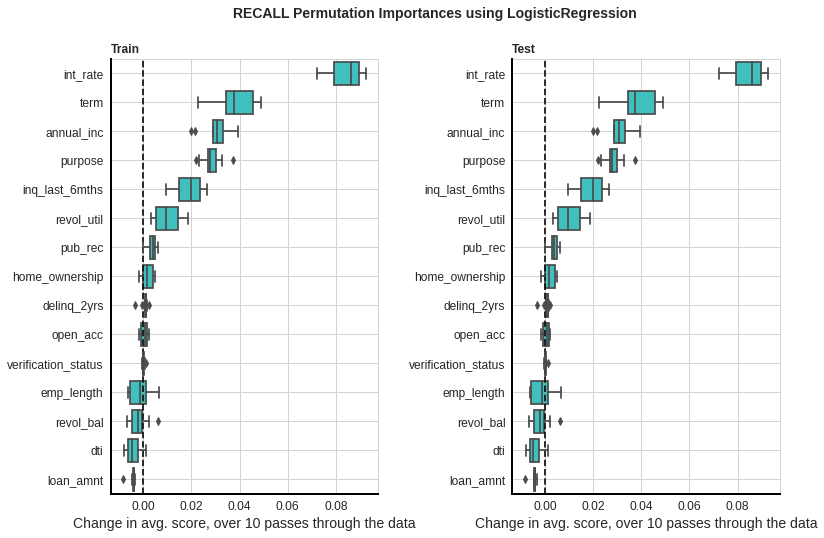

In [34]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["recall_binary"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

CPU times: user 755 ms, sys: 1.5 s, total: 2.25 s
Wall time: 1.83 s


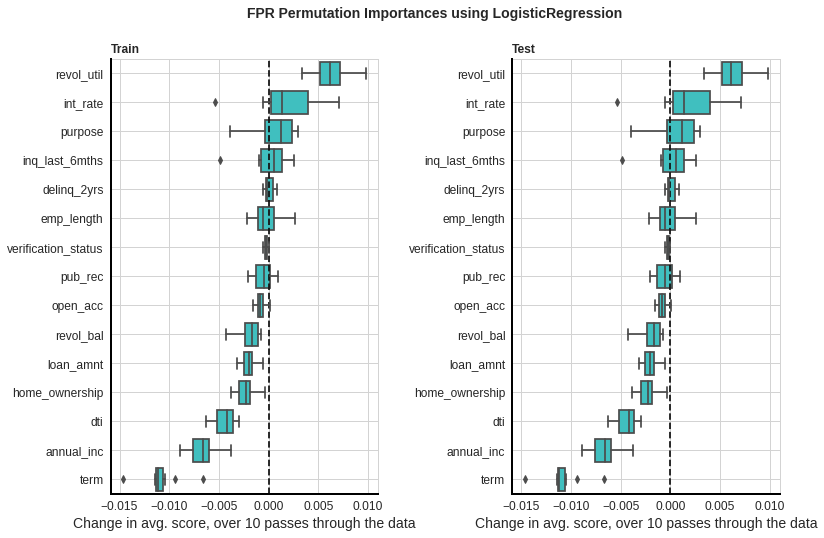

In [35]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["fpr"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

CPU times: user 840 ms, sys: 1.43 s, total: 2.27 s
Wall time: 2.19 s


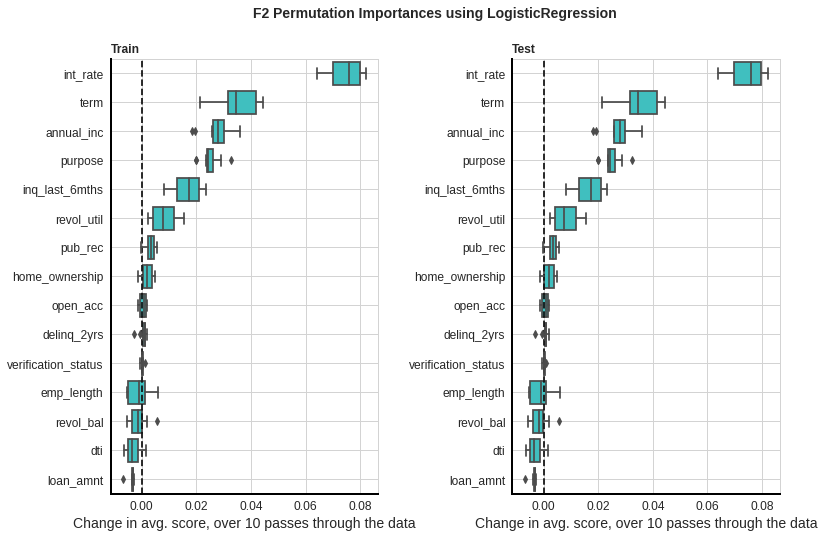

In [36]:
%%time
builtin_plot_permutation_importances(
    best_pipe,
    X_train_val,
    X_test,
    y_train_val,
    y_test,
    scorer=multi_scorers["f2"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(12, 8),
)

The process is repeated using the difference between the average difference of the model's predicted, and true return, per loan in the testing split as the scoring metric instead of the the TPR and FPR separately

CPU times: user 10.1 s, sys: 1.02 s, total: 11.1 s
Wall time: 1min 53s


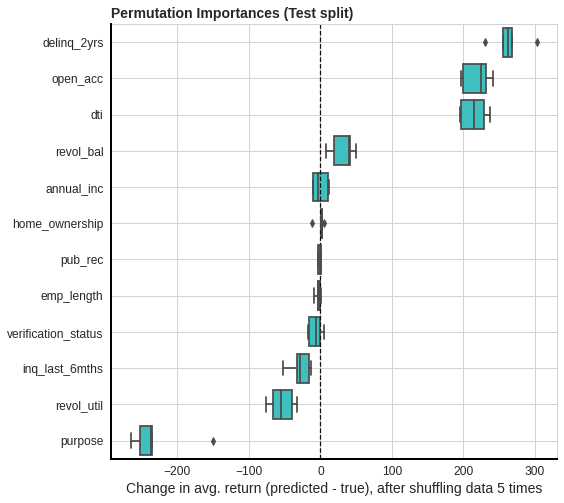

In [37]:
%%time
manual_plot_permutation_importance(
    # X_test.head(1000),
    # y_test.head(1000),
    X_test,
    y_test,
    best_pipe,
    best_t,
    5,
    "test",
    "Permutation Importances",
    14,
    12,
    14,
    "cyan",
    (8, 8),
)

**Notes**
1. The higher the absolute difference the more impactful the ML feature is to the predictive model developed here
   - a positive difference indicates the average error between the predicted and true return became larger by shuffling (the predicted return is larger than the true return by shuffling)
   - a negative difference indicates the average error between predicted and true return became larger in the negative direction by shuffling (the true return is larger than the predicted return by shuffling)
2. The `int_rate` (loan's interest rate), `term` (duration of loan) and `loan_amnt` (principal) are required to calculate the interrest income which is used in converting the model's predictions to the per-loan return. By definition, shuffling each of these columns individually will have the greatest affect this conversion. More importantly, the computation of total loan income is not sensible with unrealistic combinations of these three components. So, these three ML features are not used in determining the permutation importance.

**Observations**
1. Surprisingly, `annual_inc` (annual income) and `emp_length` (length of employment) were among the least influential value-add variables in the data.
2. The most important features are the `purpose` of the loan - recalling the distribution of this feature from exploratory data analysis, it is intuitive that importance is placed on it - `open_acc` (number of active credit lines against the borrower's name), `dti` and `delinq_2yrs`
3. The next most important features are `revol_bal` (portion of credit card spending that goes unpaid at the end of a billing cycle - [link](https://www.creditcards.com/credit-card-news/glossary/term-revolving-balance/)), `revol_util` and `inq_last_6mths` appear as important features.
4. Intuitively, it makes sense that these are important to a borrower's ability to pay back a loan. eg.
   - `revol_bal` - fraction of credit card spending that will not be recovered adds up over several monthly payment periods and directly affects whether a loan will be paid off on time or, due to the accumulation of missed payments, not on time
   - `revol_util` - fraction of used credit relative to all available revolving credit
   - `dti` - fraction of total monthly debt relative to monthly income - [link](https://www.consumerfinance.gov/ask-cfpb/what-is-a-debt-to-income-ratio-why-is-the-43-debt-to-income-ratio-important-en-1791/)
   - `open_acc` - if a borrower is using a lot of credit lines, this could be an indication of their reliance on these to cover daily expenses and would question whether they can take on the additional debt in the form of a loan
   - `inq_last_6mths` - number of times, over the last 6 months, a loan lender has reviewed a borrower's credit report as part of a loan application - [link](https://www.consumer.equifax.ca/personal/education/credit-report/understanding-hard-inquiries-on-credit-report/)
3. Since this is the **average** difference in dollars (horizontal axis) per loan, the marginal value increases in the per-loan return between pairs of features (eg. `annual_inc` vs `purpose`) should also be interpreted as an average rather than a discrete value that can be expected for every single loan.

**Disadvantages of Permutation Importances**
1. When assessing the ML model's predictions on a permuted feature, this leads to an evaluation of observations (loans) that do not make sense in practice.i.e. loans with the randomized column values may never occur in reality. Yet, these are being cast as legitimate observatoins from the data and being used to train the ML model in order to make predictions on the outcomes of such loans.
2. At its core, the randomness being introduced may lead to the results (importances) that vary significantly. This would appear as a boxplot with a large width reflecing a significant variation from one repeat to the next and within each repeat itself. It is not observed here but, if it did, will lead to less interpretable importances from this method.

#### Drop-Column Feature / Leave One Co-variate Out (LOCO) Importance

The next approach ([LOCO](https://arxiv.org/abs/2006.08482)) is identical to permutation importance, but drops a single ML feature at a time, instead of shuffling it, and then computing the difference in the ML model's performance on unseen data. A single repeat is necessary since dropping the same feature multiple times and re-running the training/prediction gives the same output. So, the boxplot has been replaced by a bar plot. As before, the three features essential to the computation of total loan income are not included here.

CPU times: user 10.7 s, sys: 2.47 s, total: 13.2 s
Wall time: 31.5 s


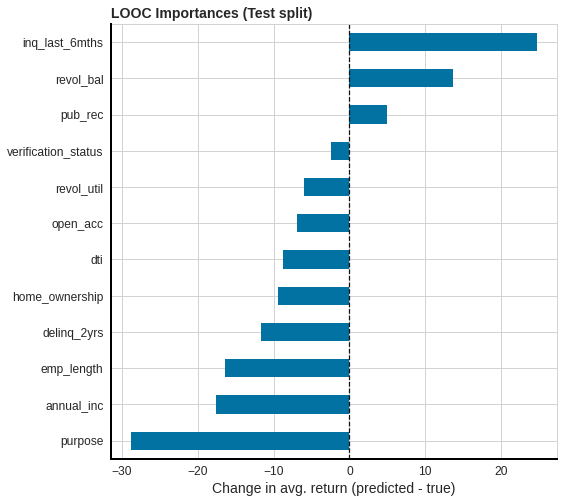

In [38]:
%%time
df_looc = manual_plot_looc_importance(
    # X_train_val.head(1000).copy(),
    # X_test.head(1000).copy(),
    # y_train_val.head(1000).copy(),
    # y_test.head(1000).copy(),
    X_train_val.copy(),
    X_test.copy(),
    y_train_val.copy(),
    y_test.copy(),
    "no_trans",
    numerical_columns,
    nominal_columns,
    df_gs["clf_obj"].iloc[0],
    best_t,
    0.5,
    "spearman",
    "test",
    "LOOC Importances",
    14,
    12,
    14,
    "cyan",
    False,
    (8, 8),
)

**Observations**
1. `purpose` and `inq_last_6mths` are the most important features
   - `inq_last_6mths` was middle-of-the-pack, but is now one of the most important
2. `annual_inc`, `emp_length` and `home_ownership` are no longer among the weakest - in this regard, it now is one of the most important
   - disagreement with permutation importances, although moving in right (more intuitive) direction
3. `open_acc`, `delinq_2yrs`, and `dti` were the among strongest, but now are middle-of-the-pack
   - disagreement with permutation importances
4. `revol_util` is among the weakest but was previously middle-of-the-pack

In summary, `emp_length` and `annual_inc` were the weakest but are now among the more important features. `purpose` remains the strongest feature. `inq_last_6mths` was middle-of-the-pack but is now among the strongest and the opposite is true for `open_acc`, `delinq_2yrs` and `dti`.

**Disadvantages of LOCO Importances**
1. When assessing the ML model's predictions without a feature, this leads to a scenario where the ML model will be trained and it will find another way to derive the same information lost by dropping a single feature if possible. So, this approach is combining two factors - the predictive power of the feature that is dropped (which is what we want to do) but also and the way the model configures itself (which, if it occurs, is not intended)
   - in the current case, this could partially explain why `open_acc` appears to have been replaced by `total_acc` and why weaker features (upon permuting them but not dropping) appear among the more important ones here
2. In the presence of a large number of ML features, this method requires re-training the model for each feature being dropped which is computationally expensive and may not be scalable in practice.

#### SHapely Additive exPlanations (SHAP) Values

The next approach (SHAP - [article](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html), [algorithm](https://arxiv.org/abs/1802.03888)) uses game theory in order to explain ML model outputs.

Attempts at using SHAP to explain a full pipeline using a model-agnostic approach were not successful as documented below.

Using `shap.Explainer(best_pipe.predict, X_train_val, model_output="margin")` produced the following error
```
Exception                                 Traceback (most recent call last)
<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
--> 269             Linear._parse_model(model)
    270         except e:

<path-here>/shap/explainers/_linear.py in _parse_model(model)
    255         else:
--> 256             raise Exception("An unknown model type was passed: " + str(type(model)))
    257 

Exception: An unknown model type was passed: <class 'function'>

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
<ipython-input-76-73e9cfc6d076> in <module>
----> 1 explainer_pipe = shap.Explainer(best_pipe.predict, X_train_val, model_output="margin")

<path-here>/shap/explainers/_explainer.py in __init__(self, model, masker, link, algorithm, output_names, feature_names, **kwargs)
     97 
     98                 # use implementation-aware methods if possible
---> 99                 if explainers.Linear.supports_model_with_masker(model, self.masker):
    100                     algorithm = "linear"
    101                 elif explainers.Tree.supports_model_with_masker(model, self.masker): # TODO: check for Partition?

<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
    269             Linear._parse_model(model)
--> 270         except e:
    271             return False
    272         return True

NameError: name 'e' is not defined
```

Using `shap.Explainer(best_pipe, X_train_val, model_output="margin")` produced the following error
```
---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
--> 269             Linear._parse_model(model)
    270         except e:

<path-here>/shap/explainers/_linear.py in _parse_model(model)
    255         else:
--> 256             raise Exception("An unknown model type was passed: " + str(type(model)))
    257 

Exception: An unknown model type was passed: <class 'sklearn.pipeline.Pipeline'>

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
<ipython-input-77-02c8ee0c218e> in <module>
----> 1 explainer_pipe = shap.Explainer(best_pipe, X_train_val, model_output="margin")

<path-here>/shap/explainers/_explainer.py in __init__(self, model, masker, link, algorithm, output_names, feature_names, **kwargs)
     97 
     98                 # use implementation-aware methods if possible
---> 99                 if explainers.Linear.supports_model_with_masker(model, self.masker):
    100                     algorithm = "linear"
    101                 elif explainers.Tree.supports_model_with_masker(model, self.masker): # TODO: check for Partition?

<path-here>/shap/explainers/_linear.py in supports_model_with_masker(model, masker)
    268         try:
    269             Linear._parse_model(model)
--> 270         except e:
    271             return False
    272         return True

NameError: name 'e' is not defined
```

Using `shap.KernelExplainer(best_pipe.predict_proba, X_train_val)` gave the following error
```
Provided model function fails when applied to the provided data set.

---------------------------------------------------------------------------
Empty                                     Traceback (most recent call last)
<path>/joblib/parallel.py in dispatch_one_batch(self, iterator)
    826             try:
--> 827                 tasks = self._ready_batches.get(block=False)
    828             except queue.Empty:

/usr/lib/python3.8/queue.py in get(self, block, timeout)
    166                 if not self._qsize():
--> 167                     raise Empty
    168             elif timeout is None:

Empty: 

During handling of the above exception, another exception occurred:

ValueError                                Traceback (most recent call last)
<ipython-input-80-911d12bf49fc> in <module>
----> 1 explainer_pipe = shap.KernelExplainer(best_pipe.predict_proba, X_train_val)

<path>/shap/explainers/_kernel.py in __init__(self, model, data, link, **kwargs)
     66         self.keep_index_ordered = kwargs.get("keep_index_ordered", False)
     67         self.data = convert_to_data(data, keep_index=self.keep_index)
---> 68         model_null = match_model_to_data(self.model, self.data)
     69 
     70         # enforce our current input type limitations

<path>/shap/utils/_legacy.py in match_model_to_data(model, data)
    110             out_val = model.f(data.convert_to_df())
    111         else:
--> 112             out_val = model.f(data.data)
    113     except:
    114         print("Provided model function fails when applied to the provided data set.")

<path>/sklearn/utils/metaestimators.py in <lambda>(*args, **kwargs)
    117 
    118         # lambda, but not partial, allows help() to work with update_wrapper
--> 119         out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
    120         # update the docstring of the returned function
    121         update_wrapper(out, self.fn)

<path>/sklearn/pipeline.py in predict_proba(self, X)
    461         Xt = X
    462         for _, name, transform in self._iter(with_final=False):
--> 463             Xt = transform.transform(Xt)
    464         return self.steps[-1][-1].predict_proba(Xt)
    465 

<path>/sklearn/compose/_column_transformer.py in transform(self, X)
    602         # TODO: also call _check_n_features(reset=False) in 0.24
    603         self._validate_features(X.shape[1], X_feature_names)
--> 604         Xs = self._fit_transform(X, None, _transform_one, fitted=True)
    605         self._validate_output(Xs)
    606 

<path>/sklearn/compose/_column_transformer.py in _fit_transform(self, X, y, func, fitted)
    456             self._iter(fitted=fitted, replace_strings=True))
    457         try:
--> 458             return Parallel(n_jobs=self.n_jobs)(
    459                 delayed(func)(
    460                     transformer=clone(trans) if not fitted else trans,

<path>/joblib/parallel.py in __call__(self, iterable)
   1046             # remaining jobs.
   1047             self._iterating = False
-> 1048             if self.dispatch_one_batch(iterator):
   1049                 self._iterating = self._original_iterator is not None
   1050 

<path>/joblib/parallel.py in dispatch_one_batch(self, iterator)
    836                 big_batch_size = batch_size * n_jobs
    837 
--> 838                 islice = list(itertools.islice(iterator, big_batch_size))
    839                 if len(islice) == 0:
    840                     return False

<path>/sklearn/compose/_column_transformer.py in <genexpr>(.0)
    459                 delayed(func)(
    460                     transformer=clone(trans) if not fitted else trans,
--> 461                     X=_safe_indexing(X, column, axis=1),
    462                     y=y,
    463                     weight=weight,

<path>/sklearn/utils/__init__.py in _safe_indexing(X, indices, axis)
    385 
    386     if axis == 1 and indices_dtype == 'str' and not hasattr(X, 'loc'):
--> 387         raise ValueError(
    388             "Specifying the columns using strings is only supported for "
    389             "pandas DataFrames"

ValueError: Specifying the columns using strings is only supported for pandas DataFrames
```

So, the transformation steps of the pipeline were [first applied](https://github.com/slundberg/shap/issues/1373#issuecomment-676788860) and then SHAP was used to only explain the ML model step of the pipeline

In [39]:
# Instantiate transformation (pre-processing) and classification (ML) pipelines
pipe_trans, pipe_clf, _ = create_pipe(
    df_gs["clf_obj"].iloc[0],
    "no_trans",
    numerical_columns,
    nominal_columns,
    0.5,
    "spearman",
)

# Pre-Process training+validation and testing splits
X_train_val_trans = pipe_trans.fit_transform(X_train_val, y_train_val)
X_test_trans = pipe_trans.transform(X_test)

# Assign column names to columns of pre-processed splits
# # Get indexes of features with correlation coefficient above specified threshold
idxs_wanted = pipe_trans.named_steps["fs"].get_feature_indexes()
# # Get column names of non-correlated features (after pre-processing)
cols_no_correlation = (
    pd.Series(
        numerical_columns
        + pipe_trans.named_steps["preprocessor"]
        .named_transformers_["onehot"]
        .get_features()
    )
    .iloc[idxs_wanted]
    .tolist()
)
# print(cols_no_correlation)
X_train_val_trans.columns = cols_no_correlation
X_test_trans.columns = cols_no_correlation
# # Change datatype of one-hot encoded features
cats_cols_categorized = X_train_val_trans.columns[
    ~X_train_val_trans.columns.isin(numerical_columns)
].tolist()
X_train_val_trans[cats_cols_categorized] = X_train_val_trans[
    cats_cols_categorized
].astype(int)
X_test_trans[cats_cols_categorized] = X_test_trans[cats_cols_categorized].astype(int)

# Train ML pipeline and verify output agrees with output from full (pre-processing + ML) pipeline
pipe_clf.fit(X_train_val_trans, y_train_val)
y_test_pred_proba = pipe_clf.predict_proba(X_test_trans)
y_test_pipe_pred_proba = best_pipe.predict_proba(X_test)
assert np.array_equal(y_test_pred_proba, y_test_pipe_pred_proba, equal_nan=False)

A correlation heatmap below shows that pre-processed features don't have correlations above the specified threshold

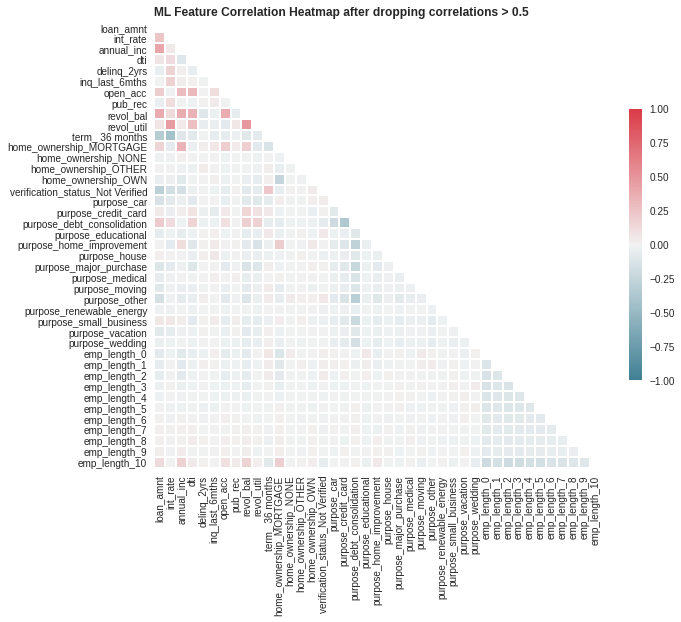

In [43]:
plot_lower_corr_heatmap(
    X_train_val_trans.corr(method="spearman"),
    "ML Feature Correlation Heatmap after dropping correlations > 0.5",
    1,
    {False: None},
    1,
    True,
    0.5,
    fig_size=(10, 10),
)

A SHAP explainer is now instantiated using only the ML step from the overall pipeline and SHAP values are obtained

In [53]:
%%time
explainer = shap.Explainer(
    pipe_clf.named_steps["clf"], X_train_val_trans, model_output="margin"
)
shap_values = explainer.shap_values(X_test_trans)

CPU times: user 5.91 ms, sys: 1.16 ms, total: 7.07 ms
Wall time: 6.42 ms


SHAP summary plots are shown below

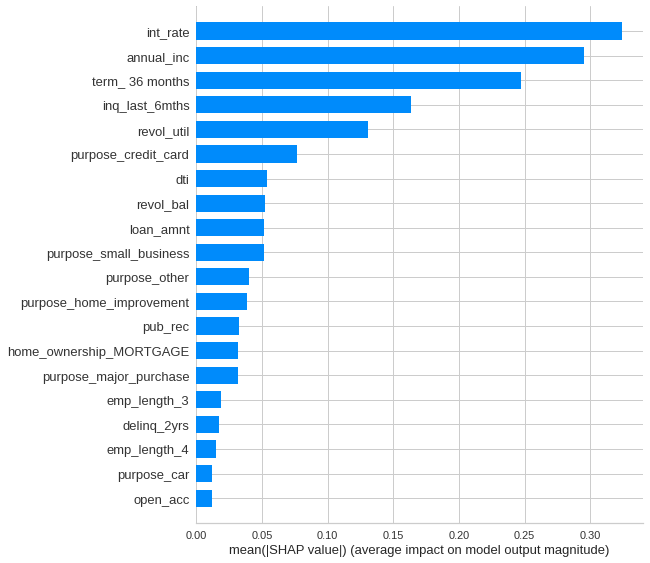

CPU times: user 374 ms, sys: 933 ms, total: 1.31 s
Wall time: 190 ms


In [54]:
%%time
shap.summary_plot(
    shap_values=shap_values, features=X_test_trans, max_display=20, plot_type="bar"
)

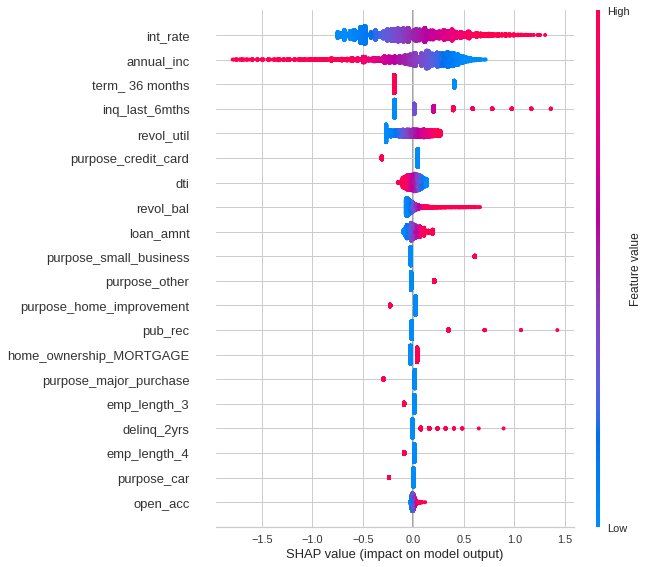

CPU times: user 1.52 s, sys: 844 ms, total: 2.37 s
Wall time: 1.27 s


In [46]:
%%time
shap.summary_plot(
    shap_values=shap_values, features=X_test_trans, max_display=20, plot_type="dot"
)

**Observations**
1. `inq_last_6mths`, `revol_util` and `purpose` are the most important features
   - `revol_util` was previously middle-of-the-pack at best, while the `inq_last_6mths` was among the strongest in LOCO and mid-range in permutation importance
   - `purpose`  has consistently been the most important feature
2. `dti` and `revol_bal` are middle-of-the pack in terms of SHAPely values, similar to LOCO and permutation importances respectively
3. `home_ownership` remains in the middle-of-the-pack zone at best
4. `delinq_2yrs`, `emp_length` and `open_acc` are the weakest features in terms of SHAPely values

#### Overall Observations about ML Feature Importances

In [66]:
X_train_val["loan_amnt"].max()

35000.0

In [65]:
X_train_val["emp_length"].max()

10

1. It may be that the max `loan_amnt` being asked for, $35,000, is not high enough to warrant using the borrower's home as collateral or emphasizing borrowers who have been working for a long time. This could explain why `home_ownership` (home values are in the hundreds of thousands) and `emp_length` (max. of 10 years) have been at best- middle-of-the-pack in their importance to the model on predicting unseen data.
2. `purpose` is the most important
3. `inq_last_6mths`, `dti` and `revol_bal` are next in line
4. `delinq_2yrs` and `open_acc` were at-worst middle-of-the-pack using either LOCO or permutation importances, but SHAPely values for them are very low
   - further investigation is needed to explain the model's dependence on these features for unseen data

### Check of ML Bias-Variance Tradeoff using Learning Curves

In order to explore the [tradeoff between bias and variance of the ML model's predictions](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), the training and cross-validation learning curves are shown below

In [47]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
X_all = pd.concat([X_train_val.iloc[:, :], X_test.iloc[:, :]]).reset_index(drop=True)
y_all = pd.concat([y_train_val[:], y_test[:]]).reset_index(drop=True)

In [48]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=best_t,
    ),
    "f2": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
    "fpr": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
}

First, these are shown using the `TPR` (or `Recall`) as the scoring metric

CPU times: user 351 ms, sys: 86.2 ms, total: 437 ms
Wall time: 3.65 s


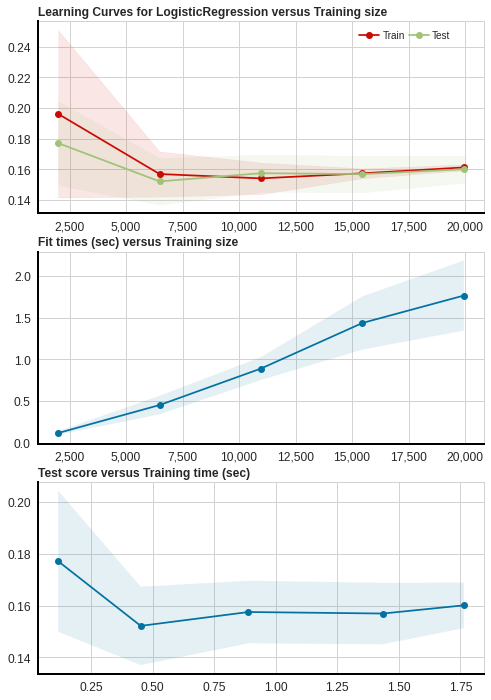

In [49]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["recall_binary"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

These are now shown using the `FPR` as the scoring metric

CPU times: user 227 ms, sys: 22.6 ms, total: 249 ms
Wall time: 2.87 s


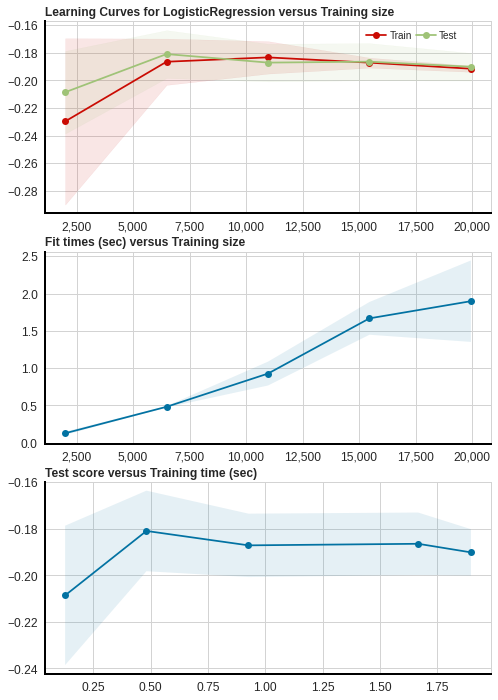

In [50]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["fpr"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

Lastly, these are now shown using the `F2` score as the scoring metric

CPU times: user 251 ms, sys: 14.6 ms, total: 266 ms
Wall time: 2.87 s


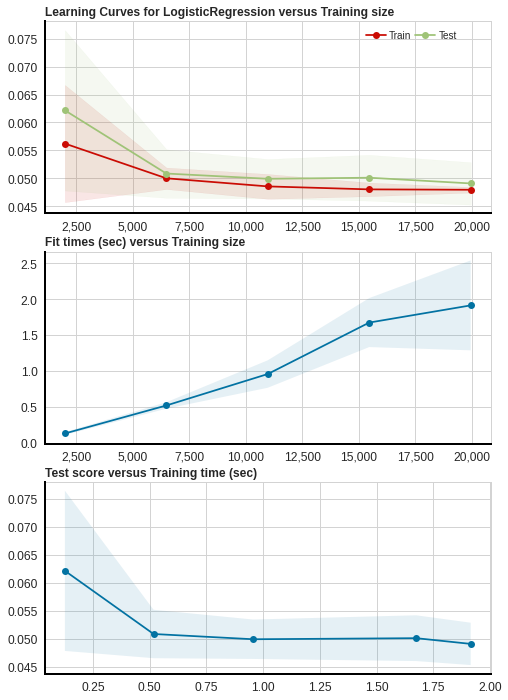

In [51]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["f2"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

As with the ML feature permutation importances, poor performance is expected for these metrics since the discrumination threshold was not chosen to optimize any of them. Instead, the focus was on the cost function - here, this is the model's predicted return per loan. So, these learning curves are repeated using the per-loan difference between the predicted and true returns (i.e. the mean error of the model's predictions) as the scoring metric

,train_size|,train_err|mean,train_err|std,test_err|mean,test_err|std,fit_time|mean,fit_time|std,clf|first
0,4987,2123.659985,40.818175,2252.052429,160.356096,0.197608,0.086355,LogisticRegression
1,9975,2064.371896,17.107442,2037.351251,126.248742,0.303158,0.123582,LogisticRegression
2,14962,2082.809957,6.827066,2007.311459,60.806771,0.506112,0.353198,LogisticRegression
3,19950,2073.278701,16.926420,2031.312937,62.405146,0.564203,0.288065,LogisticRegression


CPU times: user 189 ms, sys: 74.9 ms, total: 264 ms
Wall time: 1min 50s


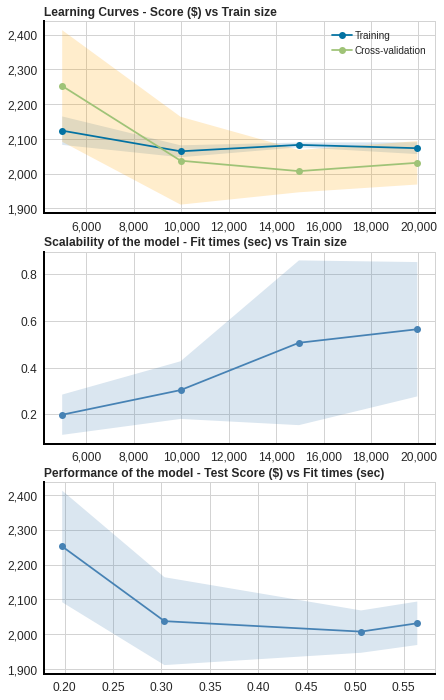

In [72]:
%%time
scores, train_sizes = learning_curve(best_pipe, X_all, y_all, cv, 5, best_t)
scores_grouped = scores.groupby(["train_size"]).agg({"train_err": ["mean", "std"], "test_err": ["mean", "std"], "fit_time": ["mean", "std"], "clf":"first"}).reset_index()
scores_grouped.columns = scores_grouped.columns.map('|'.join)
display(scores_grouped)
manual_learning_curve(
    scores_grouped,
    alpha=0.2,
    hspace=0.2,
    wspace=0.2,
    axis_tick_label_fontsize=12,
    figsize=(7, 12),
)

**Observations**
1. Both training and cross-validation errors are larger (more negative) than $\$$1,000. If the business objective was to predict the average return<sup>[1](#myfootnote1)</sup>
 per loan to within $\$$1,000 of the true return<sup>[1](#myfootnote1)</sup> earned per loan, then the error in the model's predictions (both on training and cross-validation splits of the data) would be considered high. This is an indication that the model's predictions suffer from high bias.
2. The gap between the two learning curves is small, indicating the presence of low variance in the model's predictions.
3. Combined, this indicates that the best model with the selected discrimination threshold is underfitting the training data. Adding data is unlikely to remedy this problem. This is seen from the convergence of the two learning curves as the size of the training data is increased.
4. Further work should focus on extracting more features from the dataset - currently only a single ML feature `is_employed` (a binary column indicating whether the applicant was employed or not at the time of applying for the loan on Lending Club) was extracted.

<a name="myfootnote1">1</a>: or loss, depending on whether the loan is paid off on time or not

In [67]:
y_pred_test_selected_threshold_series = pd.Series(
    y_pred_test_selected_threshold, index=X_test.index, name="pred"
)
df_tp = df[["addr_state"]].merge(
    pd.concat(
        [
            X_test[
                [
                    "purpose",
                    "home_ownership",
                    "emp_length",
                    "term",
                ]
                + numerical_columns
            ],
            y_test,
            y_pred_test_selected_threshold_series,
        ],
        axis=1,
    ),
    left_index=True,
    right_index=True,
    how="inner",
)

In [68]:
df_tp["misclassified"] = df_tp["is_default"] != df_tp["pred"]
display(df_tp)
display(df_tp.dtypes.to_frame())

,addr_state,purpose,home_ownership,emp_length,term,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,is_default,pred,misclassified
1,GA,car,RENT,0,60 months,2500.0,15.27,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,1,1,False
2,IL,small_business,RENT,10,36 months,2400.0,15.96,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,0,1,True
3,CA,other,RENT,10,36 months,10000.0,13.49,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,0,0,False
6,NC,debt_consolidation,RENT,8,60 months,7000.0,15.96,47004.0,23.51,0.0,1.0,7.0,0.0,17726.0,85.6,0,1,True
9,TX,other,RENT,0,60 months,5375.0,12.69,15000.0,18.08,0.0,0.0,2.0,0.0,9279.0,36.5,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,IN,credit_card,MORTGAGE,7,36 months,5300.0,8.38,74000.0,14.37,0.0,0.0,15.0,0.0,6844.0,14.4,0,0,False
39772,NY,home_improvement,MORTGAGE,2,36 months,3000.0,10.28,200000.0,0.00,1.0,0.0,5.0,0.0,0.0,0.0,0,0,False
39775,WI,home_improvement,MORTGAGE,0,36 months,5000.0,8.07,180000.0,5.55,0.0,0.0,12.0,0.0,40934.0,26.3,0,0,False
39776,WI,home_improvement,MORTGAGE,2,36 months,5000.0,9.33,180000.0,11.93,0.0,1.0,16.0,0.0,60568.0,39.2,0,0,False


,0
addr_state,object
purpose,object
home_ownership,object
emp_length,int64
term,object
loan_amnt,float64
int_rate,float64
annual_inc,float64
dti,float64
delinq_2yrs,float64


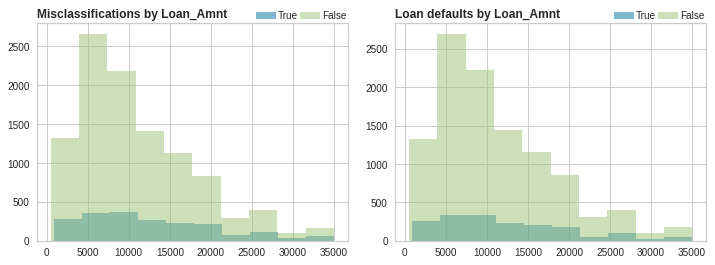

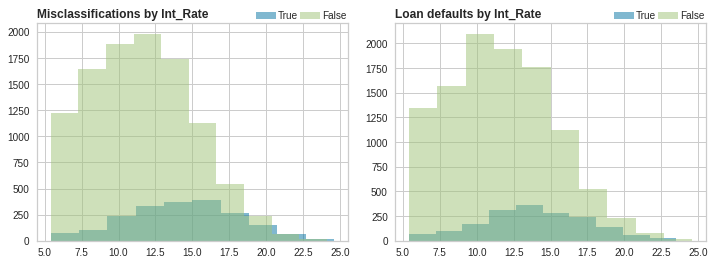

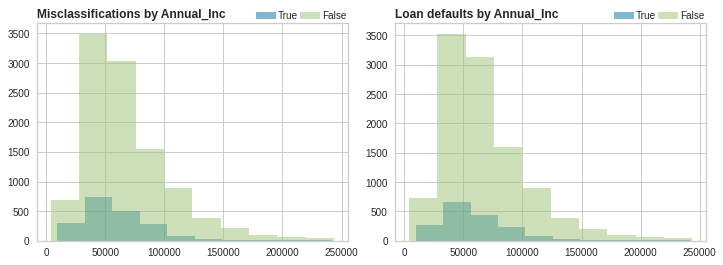

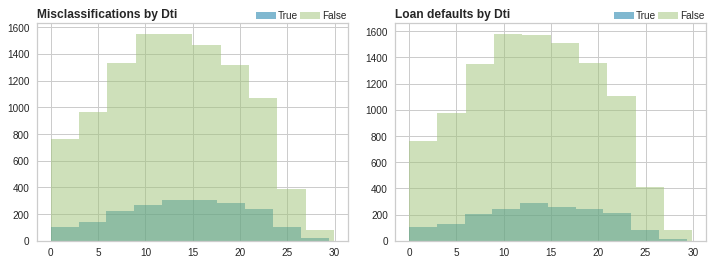

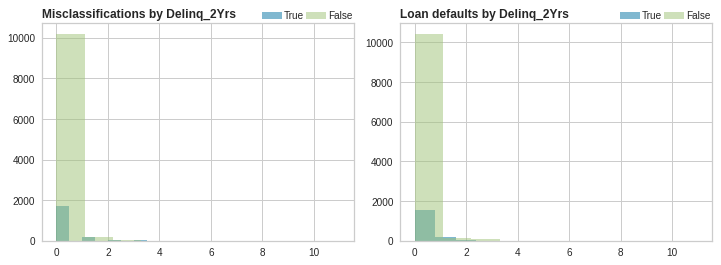

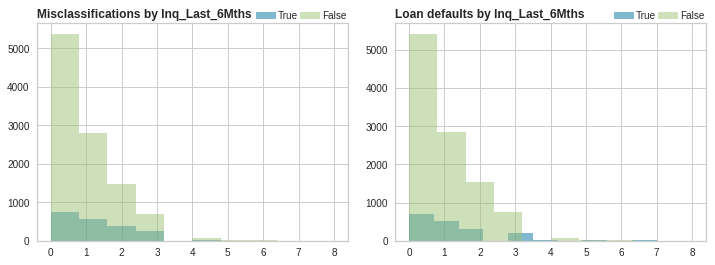

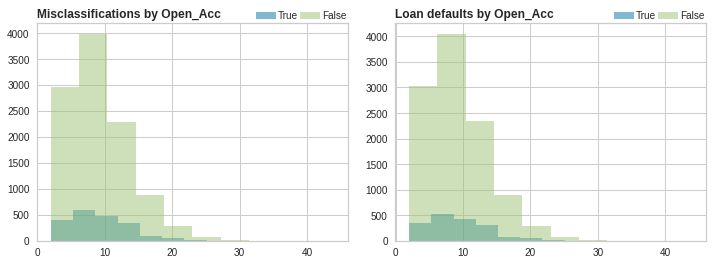

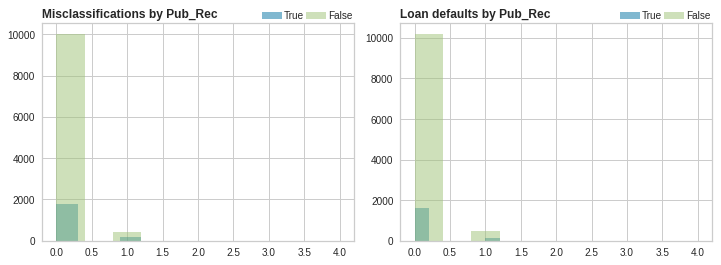

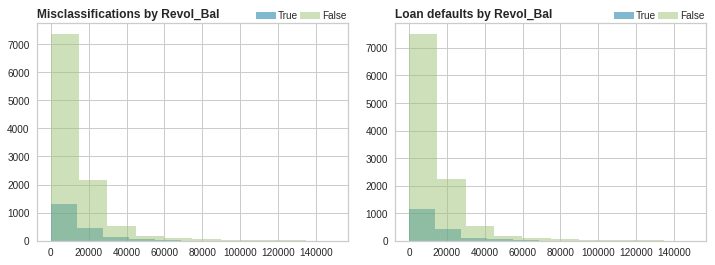

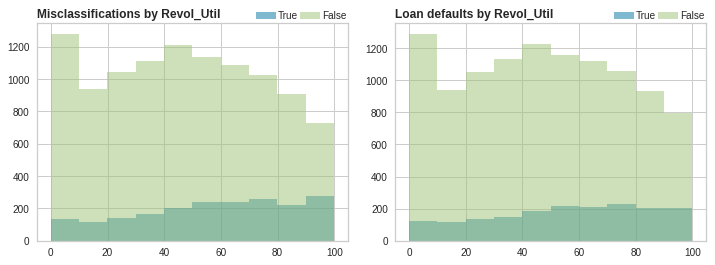

In [69]:
for c in numerical_columns:
    plot_grouped_histogram(df_tp, c, (0.675, 1.1), 0.5, 0.15, (12, 4))

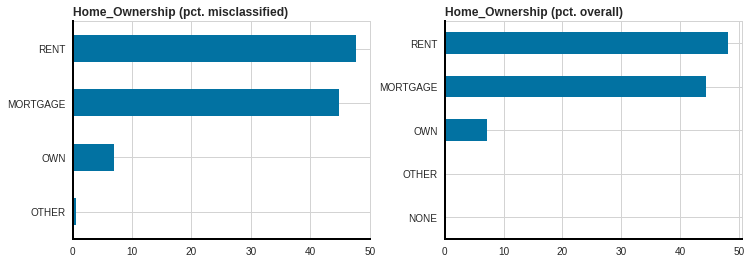

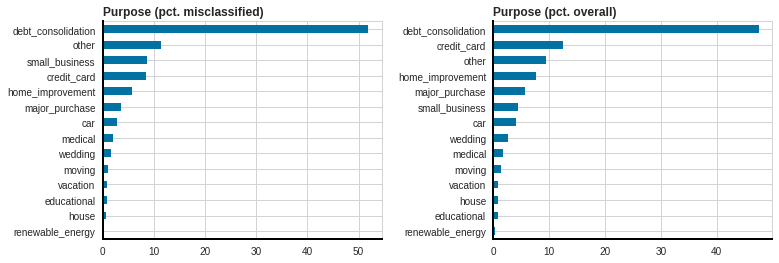

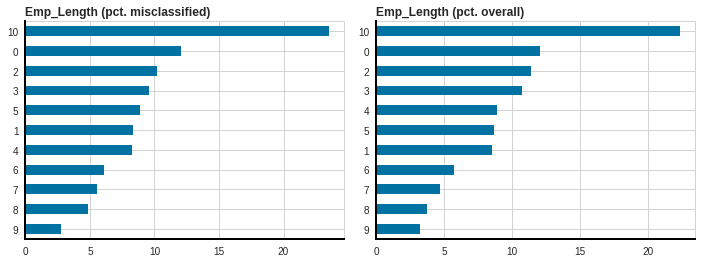

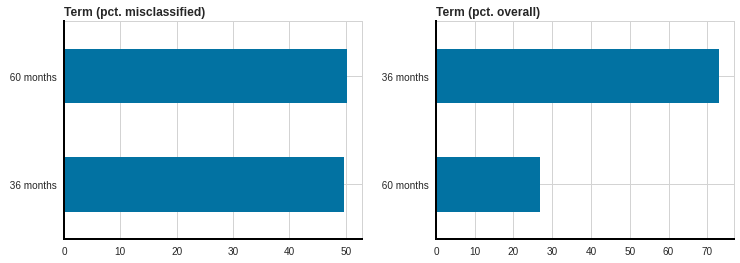

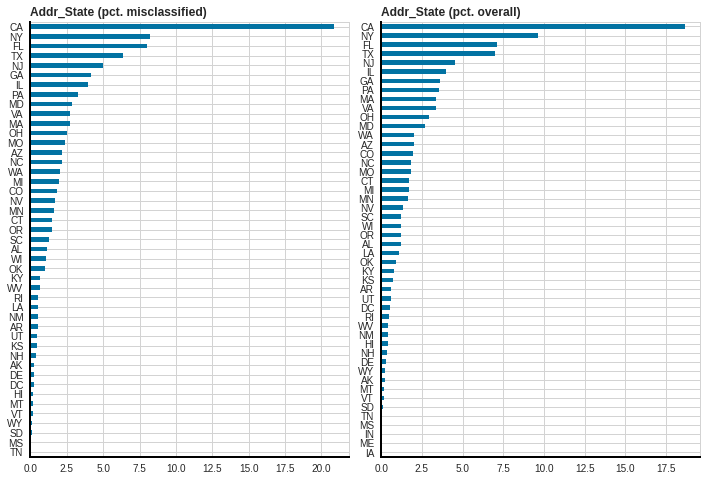

In [71]:
for col, wspace, fig_size in zip(
    ["home_ownership", "purpose", "emp_length", "term", "addr_state"],
    [0.25, 0.4, 0.1, 0.25, 0.1],
    [(12, 4), (12, 4), (12, 4), (12, 4), (12, 8)],
):
    plot_grouped_bar_chart(df_tp, col, "misclassified", wspace, fig_size=fig_size)

**Observations**
1. NY and FL have a relatively higher number of misclassifications than expected based on the frequency of loans attributed to these two states. By comparison, TX has a relatively smaller number than expected.
2. In terms of the `Employment Length` and `Purpose` columns of the data, the incorrect model predictions follow the frequency of the data - more commonly occurring categories in each of these columns are misclassified.
3. The model has approx. the same difficulty (LHS plot) in predicting the outcome for home owners who pay Rent or take a Mortgage to what is observed from the data (RHS plot).
4. For the Term column of the data
   - although nearly 75% of the loans (RHS plot) required 36 monthly payments, the model found here has nearly the same difficulty (LHS plot) predicting loans requiring 36 or 60 monthly payments. The model has trouble with predicting infrequently occurring term loans (60 months) than those that occur more commonly (36 months).

## Conclusion and Future Work

Further iterations of this project should focus on the following
  - Feature Engineering
    - extracting more machine learning features from the raw Lending Club data
      - consider a less stringent threshold (currently 50%) for dropping features with missing data
        - this could possibly re-introduce some features into the dataset that hopefully add predictive power to the models tried
  - HyperParameter Tuning
    - additional ML model hyper-parameter tuning
  - Feature Pre-Processing
    - other techniques to remove outliers (currently filtering, based on univariate visualization, was used) and correlated features (currently a simple rule is used drop highly correlated features) in the dataset before the ML process begins
  - Interpretability
    - additional techniques for interpreting the importance of features to the ML model's predictions on unseen data, especially around the `delinq_2yrs`, `emp_length` and `open_acc` features which seem to be the most sensitive to the method used to explore feature importances
  - Features attributed to ML model performance
    - based on incorrect model predictions, further exploration (incl. outlier removal) of the loan term column from the data is warranted
  - Other factors
    - Actual training data and monetary cost function assignments (currently taken from the confusion matrix and total loan income calculations) could be more complex
      - eg. including higher interest rate due to missed payments that do not result in default
    - Some borrowers who are predicted to pay off the loan on time will default
      - Including a probability of default, despite being predicted not to, in the cost (returns) function , used for threshold tuning, could provide a better ROI on an investor's funding rounds